**CÀI ĐẶT VÀ CẤU HÌNH MÔI TRƯỜNG**

In [1]:
!apt-get update -qq
!apt-get install -y openjdk-11-jdk-headless > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [2]:
import os, findspark
os.environ["JAVA_HOME"]  = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
spark = SparkSession.builder \
    .appName("CrossSellingMBA") \
    .master("local[*]") \
    .config("spark.driver.memory", "6g") \
    .getOrCreate()

print("SparkSession started successfully!")

SparkSession started successfully!


**SETUP DATA PATH**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_path = '/content/drive/MyDrive/data/online_retail_II.csv'
# thay path phù hợp để chạy trên máy cá nhân
# header=True: Dùng dòng đầu tiên làm tên cột
# inferSchema=True: Tự động suy luận kiểu dữ liệu
df_raw = spark.read.csv(data_path,
                        header=True,
                        inferSchema=True,
                        encoding='ISO-8859-1')

# Đổi tên cột "Customer ID" (có dấu cách) thành "CustomerID" (viết liền)
df_raw = df_raw.withColumnRenamed("Customer ID", "CustomerID")

print("Data loaded into PySpark DataFrame.")
df_raw.printSchema()
df_raw.show(5, truncate=False)

Data loaded into PySpark DataFrame.
root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)

+-------+---------+-----------------------------------+--------+-------------------+-----+----------+--------------+
|Invoice|StockCode|Description                        |Quantity|InvoiceDate        |Price|CustomerID|Country       |
+-------+---------+-----------------------------------+--------+-------------------+-----+----------+--------------+
|489434 |85048    |15CM CHRISTMAS GLASS BALL 20 LIGHTS|12      |2009-12-01 07:45:00|6.95 |13085.0   |United Kingdom|
|489434 |79323P   |PINK CHERRY LIGHTS                 |12      |2009-12-01 07:45:00|6.75 |13085.0   |United Kingdom|
|489434 |79323W   | WHITE CHERRY LIGHTS      

**XỬ LÝ DỮ LIỆU**

**1.   Phân tích Khám phá Dữ liệu (EDA)**


In [5]:
# 1. Đếm tổng số dòng
total_rows = df_raw.count()
print(f"\nTổng số dòng ban đầu: {total_rows:,}")

# 2. Xem thống kê mô tả cho các cột số
print("\nThống kê mô tả (cho cột số):")
df_raw.describe(["Quantity", "Price"]).show()

# 3. Kiểm tra số lượng giá trị NULL ở các cột quan trọng
print("\nKiểm tra giá trị NULL:")
df_raw.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in ["Invoice", "StockCode", "Description", "CustomerID", "Country"]
]).show()


Tổng số dòng ban đầu: 1,067,371

Thống kê mô tả (cho cột số):
+-------+------------------+------------------+
|summary|          Quantity|             Price|
+-------+------------------+------------------+
|  count|           1067371|           1067371|
|   mean|   9.9388984711033| 4.649387727413342|
| stddev|172.70579407675524|123.55305872146378|
|    min|            -80995|         -53594.36|
|    max|             80995|           38970.0|
+-------+------------------+------------------+


Kiểm tra giá trị NULL:
+-------+---------+-----------+----------+-------+
|Invoice|StockCode|Description|CustomerID|Country|
+-------+---------+-----------+----------+-------+
|      0|        0|       4382|    243007|      0|
+-------+---------+-----------+----------+-------+



Dựa trên kết quả EDA, chúng ta xác định các vấn đề chính cần xử lý:

- **Giá trị không hợp lệ (Invalid Values):** Kết quả describe() cho thấy cột Quantity có giá trị tối thiểu (min) là âm (vd: -80995). Đây là các giao dịch trả hàng/hủy đơn (thường có Invoice bắt đầu bằng 'C'). Chúng ta sẽ loại bỏ các dòng này vì mục tiêu của MBA là phân tích các mặt hàng được mua cùng nhau.

- **Dữ liệu thiếu (Missing Data):** Cột CustomerID có 243,007 giá trị NULL và Description có 4,382 giá trị NULL. Vì không thể xác định "giỏ hàng" nếu không biết CustomerID hoặc Description của sản phẩm, các dòng này bắt buộc phải được loại bỏ.

In [6]:
# Tạo bảng phụ để làm sạch dữ liệu
df_processing = df_raw

# 1. Xử lý giá trị Null (NaN)
print(f"\nSố dòng trước khi xử lý NULL: {df_processing.count():,}")
df_processing = df_processing.dropna(subset=["CustomerID", "Description"])
print(f"Số dòng sau khi xử lý NULL (ở CustomerID, Description): {df_processing.count():,}")

# 2. Xử lý trùng dòng
print(f"\nSố dòng trước khi xử lý trùng: {df_processing.count():,}")
df_processing = df_processing.distinct()
print(f"Số dòng sau khi xử lý trùng: {df_processing.count():,}")

# 3. Xử lý Quantity và Đơn hủy (Bắt đầu bằng chữ C ở cột InvoiceNo)
print(f"\nSố dòng trước khi xử lý Quantity/Đơn hủy: {df_processing.count():,}")
df_processing = df_processing.filter(
    (F.col("Quantity") > 0) &
    (~F.col("Invoice").startswith("C"))
)
print(f"Số dòng sau khi chỉ giữ lại giao dịch hợp lệ: {df_processing.count():,}")

# Làm sạch Description
df_processing = df_processing.withColumn(
    "Description",
    F.trim(F.lower(F.col("Description")))
)

print("\nDữ liệu sao khi được làm sạch:")
df_processing.show(5, truncate=False)


Số dòng trước khi xử lý NULL: 1,067,371
Số dòng sau khi xử lý NULL (ở CustomerID, Description): 824,364

Số dòng trước khi xử lý trùng: 824,364
Số dòng sau khi xử lý trùng: 797,885

Số dòng trước khi xử lý Quantity/Đơn hủy: 797,885
Số dòng sau khi chỉ giữ lại giao dịch hợp lệ: 779,495

Dữ liệu sao khi được làm sạch:
+-------+---------+-----------------------------------+--------+-------------------+-----+----------+--------------+
|Invoice|StockCode|Description                        |Quantity|InvoiceDate        |Price|CustomerID|Country       |
+-------+---------+-----------------------------------+--------+-------------------+-----+----------+--------------+
|489446 |22125    |union jack hot water bottle        |12      |2009-12-01 10:06:00|5.95 |13758.0   |United Kingdom|
|489520 |35071    |assorted santa christmas decoration|12      |2009-12-01 11:41:00|0.85 |14911.0   |EIRE          |
|489536 |21650    |assorted tutti frutti bracelet     |1       |2009-12-01 12:13:00|0.65 |16393.

**2.   Chẩn đoán tính nhất quán của Dữ liệu:** **Kiểm tra sự không nhất quán giữa mã sản phẩm (StockCodes) và mô tả (Descriptions)**


In [7]:
# 1. Đếm số lượng Description duy nhất cho mỗi StockCode
diagnostic_counts = df_processing.groupBy("StockCode") \
                                .agg(F.countDistinct("Description").alias("DistinctDescriptionCount"))

# 2. Lọc ra những StockCode có nhiều hơn 1 Description
inconsistent_codes_df = diagnostic_counts.filter(F.col("DistinctDescriptionCount") > 1)

print(f"Tìm thấy {inconsistent_codes_df.count()} mã StockCodes có nhiều hơn 1 Description.")

# 3. Hiển thị ví dụ các mô tả khác nhau
print("\nVí dụ cụ thể về các Description khác nhau cho cùng một StockCode:")

# Join với bảng gốc để lấy các mô tả
df_examples = df_processing.join(
    inconsistent_codes_df,
    "StockCode",
    "inner"
)

# Nhóm lại và hiển thị các bộ mô tả khác nhau
df_examples_collected = df_examples.groupBy("StockCode") \
                                   .agg(F.collect_set("Description").alias("AllDescriptions"))

df_examples_collected.show(10, truncate=False)

Tìm thấy 598 mã StockCodes có nhiều hơn 1 Description.

Ví dụ cụ thể về các Description khác nhau cho cùng một StockCode:
+---------+-------------------------------------------------------------------------------------+
|StockCode|AllDescriptions                                                                      |
+---------+-------------------------------------------------------------------------------------+
|15058A   |[blue white spots garden parasol, blue polkadot garden parasol]                      |
|16012    |[food/drink sponge stickers, food/drink spunge stickers]                             |
|16156L   |[wrap carousel, wrap, carousel]                                                      |
|17129F   |[blue glass gems in bag, deep blue glass gems in bag]                                |
|20615    |[blue polkadot passport cover, blue spotty passport cover]                           |
|20665    |[red spotty purse, red retrospot purse]                                            

- Con số **Unique_Clean_Descriptions (5.240)** lớn hơn **Unique_StockCodes (4.631)** tới 609 giá trị. Điều này chứng minh một vấn đề nghiêm trọng về tính nhất quán của dữ liệu: Một StockCode (mã sản phẩm) đang được liên kết với nhiều Description (mô tả) khác nhau.

In [8]:
from pyspark.sql.window import Window

# 1. Đếm số lần xuất hiện của mỗi cặp (StockCode, Description đã sạch)
code_desc_counts = df_processing.groupBy("StockCode", "Description").count()

# 2. Tìm Description phổ biến nhất cho mỗi StockCode
windowSpec = Window.partitionBy("StockCode").orderBy(F.col("count").desc())

# 3. Gán hạng (rank), hạng 1 là phổ biến nhất
code_desc_ranked = code_desc_counts.withColumn("rank", F.row_number().over(windowSpec))

# 4. Lọc lấy bảng map "chuẩn": chỉ giữ lại hạng 1 (Giờ đây đã là duy nhất)
df_mapping = code_desc_ranked.filter(F.col("rank") == 1) \
                             .select("StockCode", F.col("Description").alias("Canonical_Description"))

# 5. Join lại với bảng chính để "ép" tất cả các dòng dùng Description chuẩn
df_cleaned = df_processing.join(df_mapping, "StockCode", "inner") \
                          .drop("Description") # Bỏ cột description cũ, giữ cột chuẩn mới

# === KIỂM TRA LẠI ===
print(f"Số dòng ban đầu (hợp lệ): {df_processing.count():,}")
print(f"Số dòng sau khi chuẩn hóa Code-Description: {df_cleaned.count():,}")

# Kiểm tra lại số lượng unique
counts_row = df_cleaned.select(
    F.countDistinct("StockCode").alias("Unique_StockCodes"),
    F.countDistinct("Canonical_Description").alias("Unique_Descriptions")
).first()

print(f"\nSố StockCodes duy nhất sau chuẩn hóa: {counts_row['Unique_StockCodes']:,}")
print(f"Số Descriptions duy nhất sau chuẩn hóa: {counts_row['Unique_Descriptions']:,}")

print("\nDữ liệu sau khi làm sạch hoàn toàn (Schema mới):")
df_cleaned.printSchema()
df_cleaned.show(5, truncate=False)

Số dòng ban đầu (hợp lệ): 779,495
Số dòng sau khi chuẩn hóa Code-Description: 779,495

Số StockCodes duy nhất sau chuẩn hóa: 4,631
Số Descriptions duy nhất sau chuẩn hóa: 4,593

Dữ liệu sau khi làm sạch hoàn toàn (Schema mới):
root
 |-- StockCode: string (nullable = true)
 |-- Invoice: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- Canonical_Description: string (nullable = true)

+---------+-------+--------+-------------------+-----+----------+--------------+-----------------------------------+
|StockCode|Invoice|Quantity|InvoiceDate        |Price|CustomerID|Country       |Canonical_Description              |
+---------+-------+--------+-------------------+-----+----------+--------------+-----------------------------------+
|22254    |490959 |12      |2009-12-08 15:14:00|1.25 |12682.0   |France       

- Lúc này StockCodes vẫn lớn hơn Descriptions vì vẫn còn trường hợp 1 Descriptions mô tả cho 2 hay nhiều StockCodes khác.

**3.   Chuyển đổi sang Định dạng MBA (Itemsets)**


In [9]:
# Nhóm theo Hóa đơn (Invoice), và thu thập các sản phẩm (đã chuẩn hóa) vào 1 list
# Dùng collect_set để đảm bảo mỗi sản phẩm chỉ xuất hiện 1 LẦN trong giỏ hàng
df_baskets = df_cleaned.groupBy("Invoice") \
                       .agg(F.collect_set("Canonical_Description").alias("Itemset"))

print(f"Tổng số giỏ hàng (hóa đơn) đã tạo: {df_baskets.count():,}")

# Lọc các giỏ hàng chỉ có 1 sản phẩm (vì chúng vô ích cho việc tìm luật kết hợp A -> B)
df_baskets_final = df_baskets.filter(F.size(F.col("Itemset")) > 1)

print(f"Số giỏ hàng hợp lệ (có từ 2 items trở lên): {df_baskets_final.count():,}")

print("\n Hoàn tất! Dữ liệu đã sẵn sàng cho MBA:")
df_baskets_final.show(10, truncate=False)

Tổng số giỏ hàng (hóa đơn) đã tạo: 36,975
Số giỏ hàng hợp lệ (có từ 2 items trở lên): 33,903

 Hoàn tất! Dữ liệu đã sẵn sàng cho MBA:
+-------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**XÂY DỰNG MÔ HÌNH VÀ KHAI PHÁ DỮ LIỆU**

**1. Huấn luyện FP-Growth (Spark)**

In [10]:
# 1.1. chuẩn bị: đảm bảo cột tên đúng
# df_baskets_final hiện có cột "Itemset" (array of strings). FP-Growth expects a column e.g. "items".
df_fpg_input = df_baskets_final.withColumnRenamed("Itemset", "items").cache()
total_baskets = df_fpg_input.count()
print(f"Total baskets: {total_baskets:,}")

# 1.2. train FP-Growth
from pyspark.ml.fpm import FPGrowth

# TUNE THESE HYPERPARAMETERS theo dataset và mục tiêu:
min_support = 0.02      # tối thiểu tần suất (thử 0.001 ~ 0.1%)
min_confidence = 0.5     # tối thiểu confidence
# max_pattern_length = 5   # optional: tối đa số items trong 1 frequent itemset

fpg = FPGrowth(itemsCol="items",
               minSupport=min_support,
               minConfidence=min_confidence)
               # maxDepth=max_pattern_length) # Removed maxDepth

model = fpg.fit(df_fpg_input)
print("FP-Growth model trained.")

Total baskets: 33,903
FP-Growth model trained.


**2. Lấy frequent itemsets & luật kết hợp**


In [12]:
# 2.1 frequent itemsets (for reference & to compute support of singletons)
model.freqItemsets.cache().show()

# 2.2 association rules returned by Spark (contains antecedent, consequent, confidence, support)
model.associationRules.show()

print(f"Số lượng frequent itemsets tìm được: {model.freqItemsets.count():,}")
print(f"Số lượng luật kết hợp tìm được: {model.associationRules.count():,}")


+--------------------+----+
|               items|freq|
+--------------------+----+
|[spaceboy birthda...| 861|
|[heart filigree d...| 706|
|[alarm clock bake...|1036|
|[alarm clock bake...| 702|
|[red retrospot tr...| 726|
|[metal sign take ...| 765|
|[white wood garde...| 804|
|[jumbo bag spaceb...| 971|
|[jam making set w...| 902|
|[pink blue felt c...| 998|
|[jumbo bag woodla...| 911|
|[memo board retro...| 737|
|[red kitchen scales]| 777|
|[woodland charlot...|1061|
|[blue harmonica i...| 815|
|[red retrospot ca...|1274|
|[round snack boxe...|1146|
|[lunch bag woodland]|1582|
|[lunch bag woodla...| 856|
|[lunch bag woodla...| 684|
+--------------------+----+
only showing top 20 rows

+--------------------+--------------------+------------------+------------------+--------------------+
|          antecedent|          consequent|        confidence|              lift|             support|
+--------------------+--------------------+------------------+------------------+---------------

**3. Lọc rules có Lift > 1**

In [11]:
rules = model.associationRules.filter(F.col("lift") >= 1)
print("Số luật mạnh:", rules.count())


Số luật mạnh: 21


**VISUALIZED VÀ ĐƯA RA KẾT LUẬN**

**1. Tiền xử lý để trực quan hóa**

In [16]:
# import thư viện
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.patches import Patch

# Chuyển Spark DataFrame sang Pandas để vẽ biểu đồ
rules_pd = rules.orderBy(F.desc("lift")).toPandas()

# Tạo cột tên luật: "A → B"
rules_pd['rule_name'] = rules_pd['antecedent'].astype(str) + " → " + rules_pd['consequent'].astype(str)

print(f"Tổng số luật mạnh (Lift ≥ 1): {len(rules_pd)}")
rules_pd.head()


Tổng số luật mạnh (Lift ≥ 1): 21


,antecedent,consequent,confidence,lift,support,rule_name
0,[roses regency teacup and saucer],[green regency teacup and saucer],0.707317,25.375842,0.022240,['roses regency teacup and saucer'] → ['green ...
1,[green regency teacup and saucer],[roses regency teacup and saucer],0.797884,25.375842,0.022240,['green regency teacup and saucer'] → ['roses ...
2,[alarm clock bakelike green],[alarm clock bakelike red],0.677606,20.081191,0.020706,['alarm clock bakelike green'] → ['alarm clock...
3,[alarm clock bakelike red],[alarm clock bakelike green],0.613636,20.081191,0.020706,['alarm clock bakelike red'] → ['alarm clock b...
4,[charlotte bag pink polkadot],[red retrospot charlotte bag],0.634477,14.388400,0.020736,['charlotte bag pink polkadot'] → ['red retros...


**2. Bar chart: Top rules theo Lift**



/tmp/ipython-input-3715292624.py:43: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0.1, 1, 1])


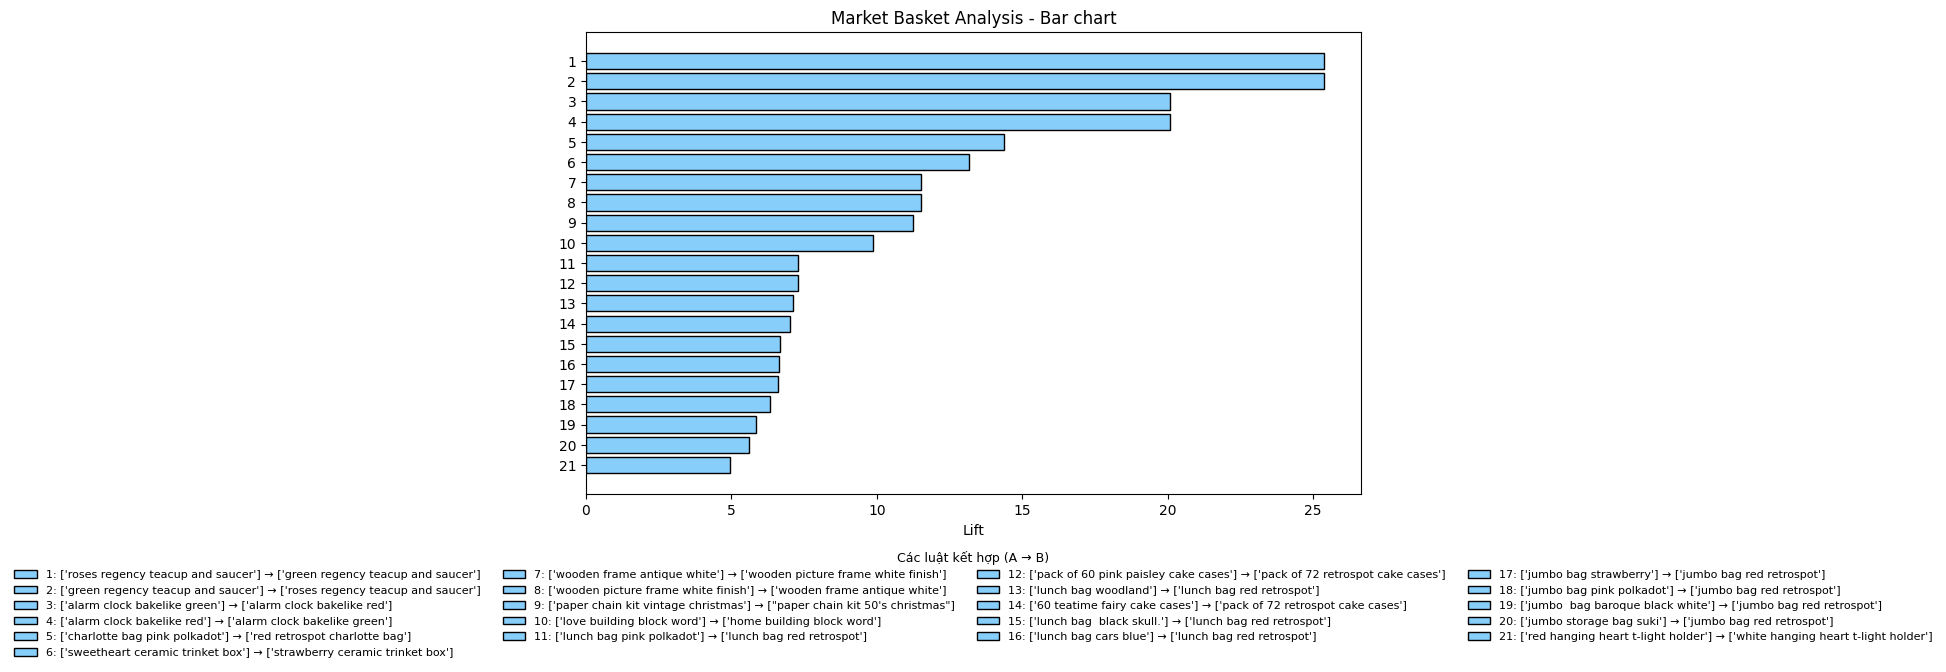

In [17]:

# Sắp xếp luật theo Lift giảm dần
rules_pd_sorted = rules_pd.sort_values(by='lift', ascending=False).reset_index(drop=True)

# Encode số thứ tự cho mỗi luật
unique_rules = rules_pd_sorted['rule_name'].unique()
rule_to_num = {rule: i+1 for i, rule in enumerate(unique_rules)}
rules_pd_sorted['rule_num'] = rules_pd_sorted['rule_name'].map(rule_to_num)

# Chuẩn bị dữ liệu cho bar chart
y_pos = np.arange(len(rules_pd_sorted))
lift_values = rules_pd_sorted['lift']
bar_color = '#87CEFA'  # xanh nhạt
edge_color = 'k'

# Vẽ bar chart
plt.figure(figsize=(10, 6))
plt.barh(y_pos, lift_values, color=bar_color, edgecolor=edge_color)

# Dùng số thứ tự làm nhãn trục Y
plt.yticks(y_pos, rules_pd_sorted['rule_num'])
plt.gca().invert_yaxis()  # Lift cao nhất trên cùng

plt.xlabel("Lift")
plt.title("Market Basket Analysis - Bar chart")

# Tạo legend nằm ngang bên dưới
legend_elements = [
    Patch(facecolor=bar_color, edgecolor=edge_color, label=f"{i+1}: {rule}")
    for i, rule in enumerate(unique_rules)
]

plt.legend(
    handles=legend_elements,
    title="Các luật kết hợp (A → B)",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8,
    title_fontsize=9,
    frameon=False
)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()


- Biểu đồ bar chart này hiển thị các luật kết hợp mạnh **(Lift ≥ 1)** được phát hiện từ dữ liệu giao dịch. Mỗi *thanh ngang tương ứng với một luật*, chiều dài của thanh thể hiện giá trị **Lift** – thanh càng dài, nghĩa là mối liên hệ giữa Antecedent (A) và Consequent (B) càng mạnh. Trục Y được đánh số thứ tự đại diện cho từng luật, với bảng chú giải bên dưới giúp liên kết số thứ tự với luật cụ thể "A → B". Biểu đồ giúp *trực quan hóa những mối quan hệ sản phẩm thường được mua cùng nhau*, hỗ trợ ra quyết định bán chéo (cross-selling) hiệu quả.

**3. Bubble chart (scatter plot)**

/tmp/ipython-input-4159765208.py:44: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0.1, 1, 1])


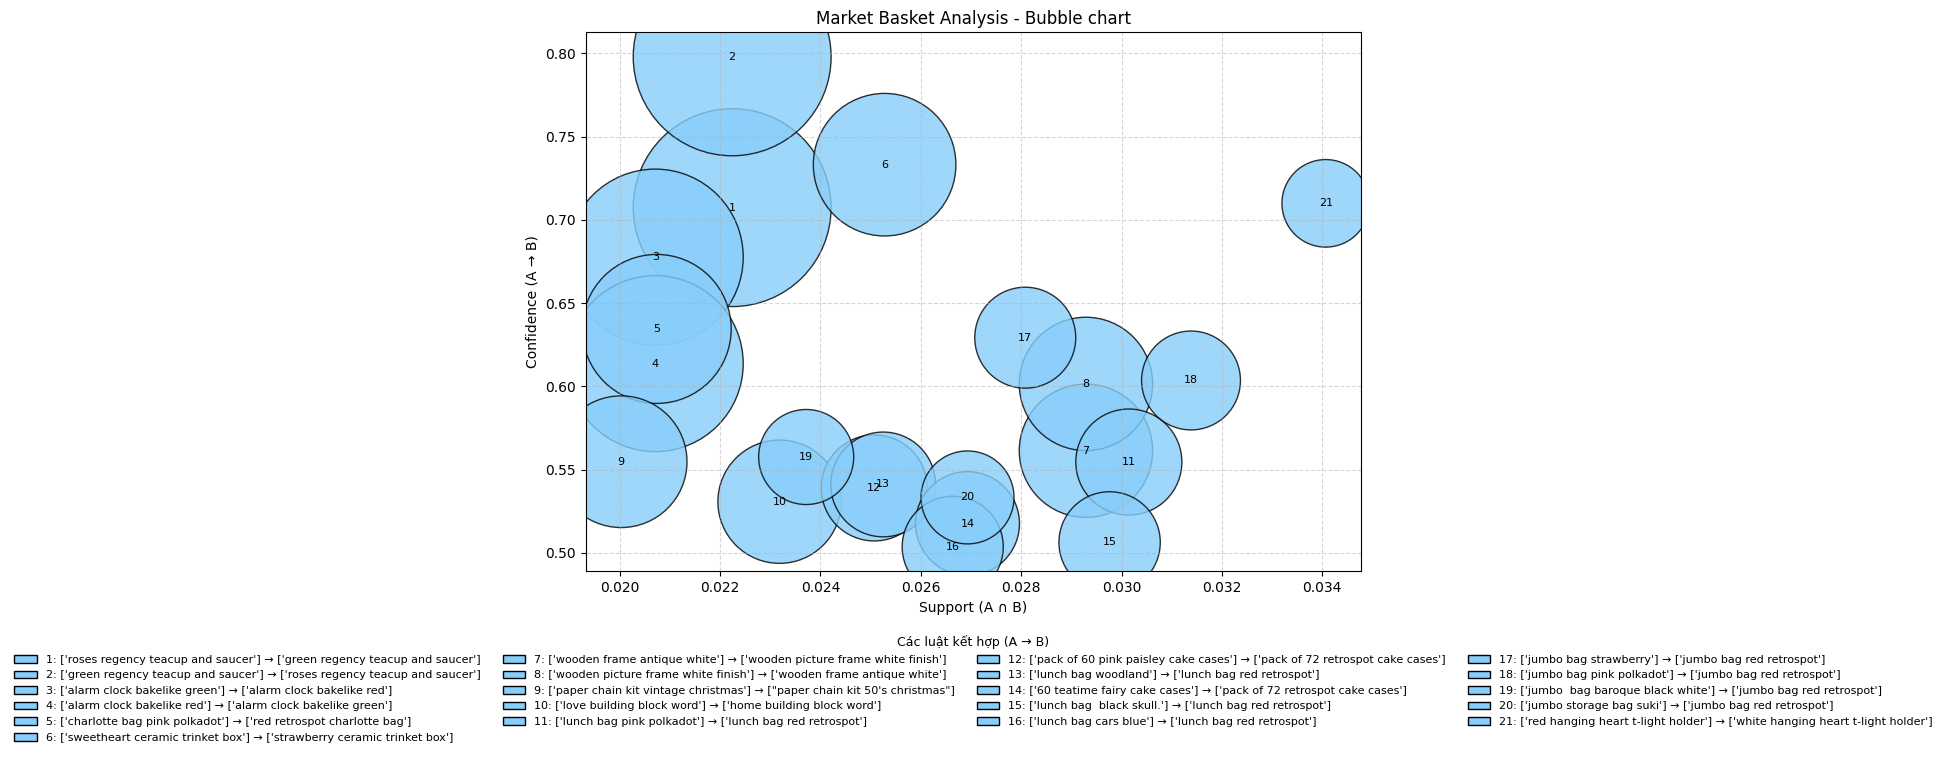

In [18]:

# 1️ Số luật = số lượng bóng
unique_rules = rules_pd['rule_name'].unique()
num_rules = len(unique_rules)

# 2️ Encode theo số thứ tự
rule_to_num = {rule: i+1 for i, rule in enumerate(unique_rules)}
rules_pd['rule_num'] = rules_pd['rule_name'].map(rule_to_num)

# 3️ Chuẩn bị dữ liệu
x = rules_pd['support']
y = rules_pd['confidence']
sizes = (rules_pd['lift']) * 800  # scale kích thước

# 4️ Vẽ scatter
plt.figure(figsize=(10, 7))
scatter = plt.scatter(x, y, s=sizes, alpha=0.8, edgecolors='k', color='#87CEFA')

# 5️ Ghi số thứ tự trên bóng
for i, txt in enumerate(rules_pd['rule_num']):
    plt.annotate(txt, (x[i], y[i]), fontsize=8, ha='center', va='center')

# 6️ Tạo legend nằm ngang bên dưới
legend_elements = [
    Patch(facecolor='#87CEFA', edgecolor='k', label=f"{i+1}: {rule}")
    for i, rule in enumerate(unique_rules)
]

plt.legend(
    handles=legend_elements,
    title="Các luật kết hợp (A → B)",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8,
    title_fontsize=9,
    frameon=False
)

# 7️ Trang trí
plt.xlabel("Support (A ∩ B)")
plt.ylabel("Confidence (A → B)")
plt.title("Market Basket Analysis - Bubble chart")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()


**Biểu đồ bong bóng Market Basket Analysis:**
- **Trục X:** Support (tần suất xuất hiện cùng nhau của A và B).
- **Trục Y:** Confidence (xác suất B xuất hiện khi có A).
- **Kích thước bong bóng:** Lift (mức độ mạnh của luật, bong bóng càng to → Lift càng cao).
- **Số trên bong bóng:** Tham chiếu legend để biết quy luật A → B.

Biểu đồ bong bóng *thể hiện các luật kết hợp trong dữ liệu giỏ hàng*. Trục X là Support (tần suất xuất hiện của A ∩ B), trục Y là Confidence (xác suất B xảy ra khi A xảy ra). Kích thước bong bóng tỷ lệ với Lift – *bong bóng càng to, luật càng mạnh*. Mỗi bong bóng được đánh số, tham chiếu với legend để biết luật tương ứng (A → B). Biểu đồ *giúp nhận diện nhanh các luật quan trọng và đáng chú ý* trong Market Basket Analysis.

**DECISION MAKING**

Dựa trên các biểu đồ trực quan ở phần trước. Doanh nghiệp có thể quan sát thấy được các quy luật $(A \Rightarrow B)$ mà Khi khách mua A, xác suất mua B cao hơn rất nhiều so với bình thường. Từ đó có thể hỗ trợ doanh nghiệp trong các quyết định knh doanh như:
  - Tập trung bán chéo (cross-sell) vào nhóm sản phẩm có chỉ số $lift$ cao
  - Ưu tiên chiến dịch marketing vào các cặp sản phẩm có Lift cao
  - Tạo gói sản phẩm (product bundle) theo nhu cầu thực tế
  - Tối ưu sắp xếp kho và logistic
  - Dự đoán tồn kho và nhập hàng
  - Thiết kế mục “Frequently Bought Together” trên website/app.
